In [2]:
from ThesisFunctions import *

In [23]:
#First we test the case with NO NOISE

print('Number of datapoints vs Number of minimas')
noise_level = 0
num_datapoints_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#num_datapoints_list = [20]
alpha = 1
initial_cond = 1

# Initialize a list to store the results.
results_list = []
data = 0 
t_i = 0
x_i = 0
num_minimas = 0

for num_datapoints in num_datapoints_list:
    trials_minimas = []  # Store the number of minima found in each trial for current num_datapoints.
    for _ in range(1):  # Perform 10 trials to average out the effects of randomness.
        # Generae data with specified number of datapoints and noise level.
        data = data_gen(num_datapoints, noise_level, initial_cond, alpha)
        x_i = np.array(data['Data'].values)
        t_i = np.array(data['Time'].values)
        #plt.scatter(t_i, x_i)
        
        # Calculate the Groebner basis.
        B = groeb(x_i, t_i)
        #print(B[1])                     
        # Find positive real roots.
        positive_roots_b= []
        
        params = find_x0_alpha_pairs(B, positive_roots_b)
    
        # # Evaluate the Hessian to check for minima.
        maxima_checks = evaluate_hessian_at_extremas(params, x_i, t_i)
            
        # # Count the number of minima.
        num_minimas = sum(1 for _, is_true in maxima_checks if is_true)

        if num_minimas == 0:
            print("Testing out newton method")
            positive_roots_b = find_roots_alternative(B[1])
            params = find_x0_alpha_pairs(B, positive_roots_b)
            maxima_checks = evaluate_hessian_at_extremas(params, x_i, t_i)
            num_minimas = sum(1 for _, is_true in maxima_checks if is_true)
            if num_minimas == 0: 
                print("No minima found, performing grid search.")
                for param in params:
                    best_params, is_edge = grid_search_around_extrema(param, data)
                    best_params2, is_edge2 = grid_search_around_extrema((0,0), data)
                    if not is_edge or not is_edge2:
                        #print(f"Found a minimum inside the grid at {best_params}.")
                        num_minimas = 1
                    else:
                        pass
                        print(f"Minimum found at the edge for {param}, likely no minimum exists.")
                        # Handle the edge case, possibly by ignoring or taking special note
                        #plot(data)

        trials_minimas.append(num_minimas)

    
    # Calculate the average number of minima for the current number of data points.
    max_minimas = np.max(trials_minimas)
    mean_minimas = np.mean(trials_minimas)
    std_minimas = np.std(trials_minimas)
    results_list.append((num_datapoints, mean_minimas, std_minimas, max_minimas))
    print(f'Number of Datapoints={num_datapoints}: Mean= {mean_minimas}, Std Dev = {std_minimas}, Max = {max_minimas}')

# Convert results to a DataFrame for better visualization.
df_results = pd.DataFrame(results_list, columns=['Number_of_Datapoints', 'Mean_Positive_Roots', 'Std_Dev_Positive_Roots', 'max_positive_roots'])

# Print the DataFrame to see the results.
print(df_results)


Number of datapoints vs Number of minimas
Testing out newton method
Number of Datapoints=2: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=3: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=4: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=5: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=6: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=7: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=8: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
No minima found, performing grid search.
Number of Datapoints=9: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
No minima found, performing grid search.
Number of Datapoints=10: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number of Datapoints=11: Mean= 1.0, Std Dev = 0.0, Max = 1
Testing out newton method
Number o

In [3]:
def grid_search_around_extrema(extrema, data, grid_size=12, step_size=0.01):
    """
    Performs a grid search around an extrema to find a local minimum.

    Parameters:
    - extrema (tuple): The (x0, alpha) around which to center the grid search.
    - data (pd.DataFrame): The observed data.
    - grid_size (int): The width/height of the grid (must be odd to have a center).
    - step_size (float): The step size between points in the grid.

    Returns:
    - tuple: (best_params, is_edge) where best_params is the best (x0, alpha) found and
             is_edge is a boolean indicating if this point is on the edge of the grid.
    """

    x0_center, alpha_center = extrema
    half_grid = grid_size // 2
    best_sse = float('inf')
    best_params = None
    is_edge = False

    for i in range(-half_grid, half_grid + 1):
        for j in range(-half_grid, half_grid + 1):
            x0 = x0_center + i * step_size
            alpha = alpha_center + j * step_size
            current_sse = sse((x0, alpha), data)
            
            if current_sse < best_sse:
                best_sse = current_sse
                best_params = (x0, alpha)
                is_edge = i in (-half_grid, half_grid) or j in (-half_grid, half_grid)

    return best_params, is_edge


In [4]:
def plot(data):
    # Define the range for alpha and x0
    alpha_range = np.linspace(-2, 2, 100)  # Adjust the range as needed
    x0_range = np.linspace(-1, 5, 100)  # Adjust the range as needed
    
    
    # Generate a meshgrid for x0 and alpha ranges
    X0, Alpha = np.meshgrid(x0_range, alpha_range)
    
    
    # Initialize an array to store SSE values
    SSE_values = np.zeros(X0.shape)
    
    
    # Compute SSE for each combination of x0 and alpha
    for i in range(len(alpha_range)):
        for j in range(len(x0_range)):
            params_ = (X0[i, j], Alpha[i, j])
            SSE_values[i, j] = sse(params_, data)
    
            
    # Creating the plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    
    # Surface plot with log scale (since data is exponential)
    surf = ax.plot_surface(X0, Alpha, np.log(np.log(SSE_values)), cmap='viridis', edgecolor='none')
    
    
    # Labels and title
    ax.set_xlabel('x0')
    ax.set_ylabel('Alpha')
    ax.set_zlabel('log SSE')
    ax.set_title('SSE as a Function of x0 and Alpha')
    
    
    # Colorbar to show the SSE scale better/clearer
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.view_init(elev=0, azim=0)
    
    # Show the plot with the adjusted view
    plt.show()


In [5]:
from scipy.optimize import newton


def find_roots_alternative(poly):
    b = sp.symbols('b')
    
    # Convert sympy polynomial to a function for Newton's method
    poly_func = sp.lambdify(b, poly, 'numpy')
    poly_derivative = sp.diff(poly, b)
    poly_derivative_func = sp.lambdify(b, poly_derivative, 'numpy')
    
    # Call sturm algo
    num_positive_roots = count_positive_roots(poly)

    # Call Newton Method
    positive_roots = find_roots_newton(poly_func, poly_derivative_func, num_positive_roots)

    return positive_roots


# Newton's method to find roots
def find_roots_newton(func, func_prime, num_roots, initial_guess_range=(0, 10), max_attempts_per_root=100):
    roots_found = []
    for _ in range(num_roots):
        root_found = False
        attempts = 0
        while not root_found and attempts < max_attempts_per_root:
            initial_guess = np.random.uniform(*initial_guess_range)
            try:
                root = newton(func, initial_guess, fprime=func_prime, maxiter=50)
                if root>0 and all(abs(root - found_root) > 1e-5 for found_root in roots_found):
                    roots_found.append(root)
                    root_found = True
            except RuntimeError:
                pass  # Handle case where Newton's method fails
            attempts += 1
        if not root_found:
            print(roots_found)
            raise ValueError("Failed to find all positive roots after specified attempts.")
    
    
    #Making sure the roots are positive MISLEADING?

    
    
    ret = [root for root in roots_found if root>0]
    return ret



In [3]:
data

,Time,Data
0,0,489/100
1,1,559/50
2,2,-387/20
3,3,4469/50
4,4,1437/50
5,5,9639/25


In [4]:
data

,Time,Data
0,0,489/100
1,1,559/50
2,2,-387/20
3,3,4469/50
4,4,1437/50
5,5,9639/25


In [5]:
data

,Time,Data
0,0,489/100
1,1,559/50
2,2,-387/20
3,3,4469/50
4,4,1437/50
5,5,9639/25


In [6]:
t_i, x_i

(array([0, 1, 2, 3, 4, 5]),
 array([489/100, 559/50, -387/20, 4469/50, 1437/50, 9639/25], dtype=object))

In [7]:
B = groeb(x_i, t_i)
B

GroebnerBasis([-41697856355294382587132669868629714413734*b**17/120286960534853829098982192802436066571875 - 6887951014716897059366257222027490115043833*b**16/842008723743976803692875349617052466003125 + 13092427002369004921472428468632252742180389*b**15/168401744748795360738575069923410493200625 + 81363357162643714242897896767759497336760067*b**14/2526026171231930411078626048851157398009375 + 146592159719946392248640199999678212892484559*b**13/721721763209122974593893156814616399431250 + 51710252027957883422174486394474941430254089*b**12/3368034894975907214771501398468209864012500 + 1059269814934352376701806907705350756056786823*b**11/3368034894975907214771501398468209864012500 + 87202860039692210878531789875412086686311777*b**10/3368034894975907214771501398468209864012500 + 12866460739723945503852504421133369263705821*b**9/30899402706200983621756893563928530862500 + 21418526618217612902020068682324867901457301*b**8/673606978995181442954300279693641972802500 + 174582496624908511520767

In [8]:
positive_roots_b = roots_symbolic(B[1])
positive_roots_b

[7.82899812740397]

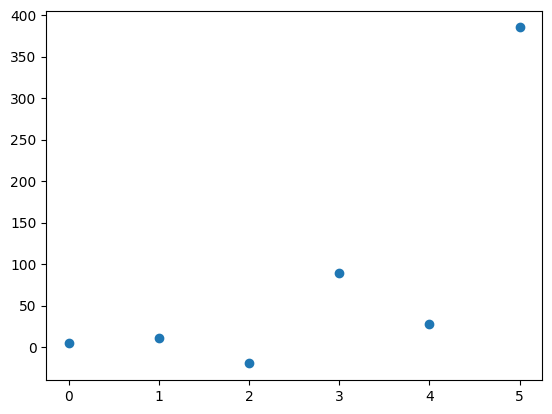

In [9]:
plt.scatter(t_i, x_i)

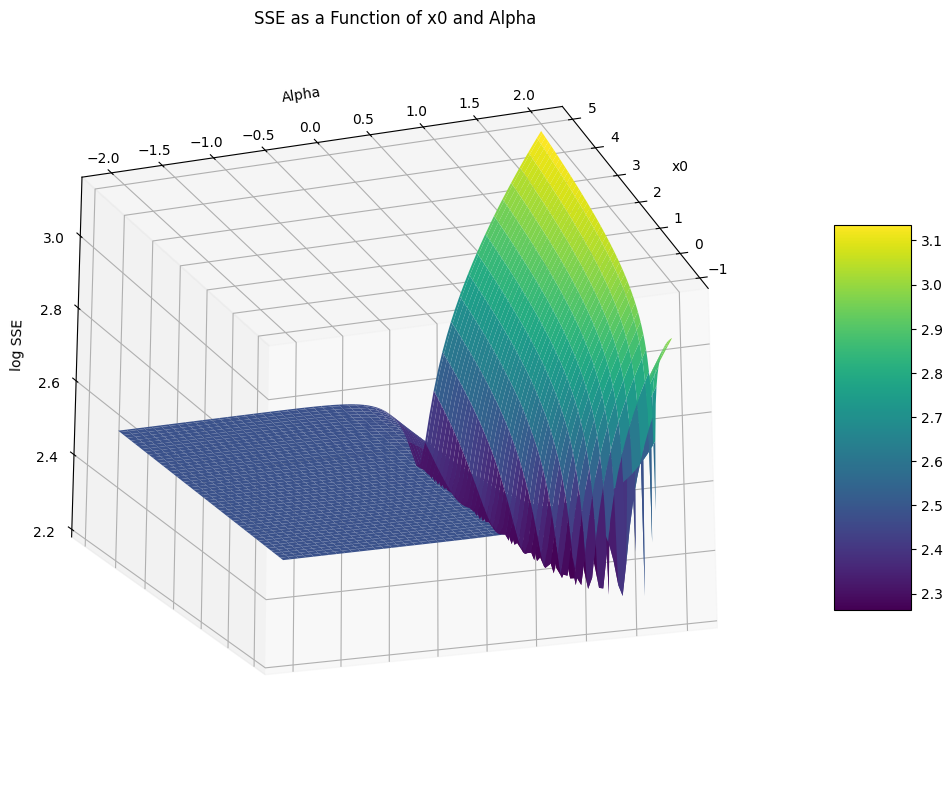

In [15]:
# Define the range for alpha and x0
alpha_range = np.linspace(-2, 2, 100)  # Adjust the range as needed
x0_range = np.linspace(-1, 5, 100)  # Adjust the range as needed


# Generate a meshgrid for x0 and alpha ranges
X0, Alpha = np.meshgrid(x0_range, alpha_range)


# Initialize an array to store SSE values
SSE_values = np.zeros(X0.shape)


# Compute SSE for each combination of x0 and alpha
for i in range(len(alpha_range)):
    for j in range(len(x0_range)):
        params_ = (X0[i, j], Alpha[i, j])
        SSE_values[i, j] = sse(params_, data)

        
# Creating the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')


# Surface plot with log scale (since data is exponential)
surf = ax.plot_surface(X0, Alpha, np.log(np.log(SSE_values)), cmap='viridis', edgecolor='none')


# Labels and title
ax.set_xlabel('x0')
ax.set_ylabel('Alpha')
ax.set_zlabel('log SSE')
ax.set_title('SSE as a Function of x0 and Alpha')


# Colorbar to show the SSE scale better/clearer
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=-20, azim=20)

# Show the plot with the adjusted view
plt.show()


In [54]:
# Assuming your model and sse functions are defined as in your previous messages

# Initial guess for the parameters [x0, alpha]
initial_guess = [1.0, 0.1]

# Minimization process
result = minimize(sse, initial_guess, args=(data,), method='L-BFGS-B', bounds=[(0, None), (None, None)])

# Results
optimized_x0 = result.x[0]
optimized_alpha = result.x[1]
success = result.success
sse_min = result.fun

print(f"Optimization Success: {success}")
print(f"Optimized x0: {optimized_x0}")
print(f"Optimized alpha: {optimized_alpha}")
print(f"Minimum SSE: {sse_min}")


Optimization Success: True
Optimized x0: 1.6491497877717656
Optimized alpha: 0.5253027742206136
Minimum SSE: 0.788253266042978


In [56]:
x0, b = sp.symbols('x0 b')
x0_recon = sp.solve(B[0].subs(b, beta), x0)[0]
x0_recon

1.64914947174533

In [57]:
test = B[1].subs(b, beta)


In [58]:
test

2.91173207034312e-6

In [60]:
print(B[1])

b**6 + 4419*b**5/51980 - 125*b**4/452 - 64141*b**3/25990 - 1247*b**2/452 - 3428*b/2599 - 109/452


In [55]:
beta = np.exp(optimized_alpha)
beta

1.6909707532312743